![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)
(https://colab.research.google.com/GitHub/)

# ARTIFICIAL INTELLIGENCE IN CHILD ABUSE AND NEGLECT

This repository hosts the project developed for the Master's Thesis in Ethics in Artificial Intelligence, for the Master's program in Artificial Intelligence at the University of Bologna, during the 2024-2025 academic year.

## Abstract:

According to the latest national investigation carried out by the Guarantor Authority for Childhood and Adolescence (Autorità Garante per l’Infanzia e
l’Adolescenza) the cases of maltreatment of children and adolescents have increased by 58% in five years. The need to have an effective tool and system for the early identification of abuse and maltreatment led Sant’Orsola’s doc-
tors to propose a collaboration with the Artificial Intelligence department of the University of Bologna to study the possibility of including AI technology
to tackle this problem.
In this thesis, after researching known solutions, we performed rule-extraction
on the professional manuals provided by the doctors. The manuals describe
the symptoms that can be found in the patients at risk, along with the behavior that the doctor should have during the patient-doctor interaction and the steps
that the doctor and the hospital should follow.
After extracting the rules, we analyzed, restructured and summarized them into questions. We studied two important instruments, ESCAPE and SCAN,
that were born with the same aim as our project and compared our questions
with the questionnaires described in these two studies.
This project resulted in the creation of a 5-item checklist that is designed to assist the medical professional that encounters an at-risk patient to determine whether the child could be a victim of abuse or maltreatment.
In the future, the aim is to incorporate this tool as a standard step during any clinical consultation of a minor, in order to drastically reduce the cases of maltreatment and abuse of children and adolescents in Italy.

This notebook contains the code used to extract the rules from the provided manuals, and test our proposed checklist on the clinical cases contained in the provided dataset.

In [6]:
# Installation of the necessary libraries
!pip install openai pymupdf
!pip install python-docx
!pip install tiktoken
!pip install PyPDF2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.7 MB/s eta 0:00:00


In [7]:
# Mount the google drive where the manuals and the database are contained
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Inilize the client OpenAI with your API key
from openai import OpenAI
#client = OpenAI(api_key="your_api_key")

## Extraction of the rules from the pdf
This code segment is composed of three parts:


1. Extraction of the text from the pdf manuals. (function estrai_testo_da_pdf)
2. Extraction of the rules using:

*   Openai's model gpt-4
*   The prompt:
            f"Estrai le regole principali per determinare se un bambino ha subito abusi " f"dal seguente testo clinico (parte {i+1}):\n\n{blocco}\n\n"
            "Scrivi le regole in forma strutturata e concisa in italiano."
*   The role:
            "Sei un esperto di medicina legale pediatrica."
*   A temperature of value 0.3

*   The text extracted from the manual divided into chunks

3. Writing of the extracted rules into a document .docx

Repeat this process for each manual

In [ ]:
import os
import time
from docx import Document
from PyPDF2 import PdfReader
from openai import OpenAI
import json
import tiktoken

# define the path to the project dir
base_dir = "/content/drive/MyDrive/nap/"


def stima_token(testo, modello="gpt-4"):
    # Use tokenizer
    encoding = tiktoken.encoding_for_model(modello)
    return len(encoding.encode(testo))

# Extraction of the text from the given pdf using PdfReader
def estrai_testo_da_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    testo = ""
    for page in reader.pages:
        testo += page.extract_text() + "\n"
    return testo

# Function to break text into chuncks
def spezza_testo_per_token(testo, max_token=2000, modello="gpt-4"):
    encoding = tiktoken.encoding_for_model(modello)
    parole = testo.split()
    blocchi, blocco_corrente = [], []

    for parola in parole:
        blocco_corrente.append(parola)
        token_correnti = len(encoding.encode(" ".join(blocco_corrente)))
        if token_correnti >= max_token:
            blocchi.append(" ".join(blocco_corrente))
            blocco_corrente = []

    if blocco_corrente:
        blocchi.append(" ".join(blocco_corrente))

    return blocchi

# function to generate the rules given a chunck of text, using Openai's gpt-4 model
def genera_regole_con_openai(testo, json_path=None):

    blocchi = spezza_testo_per_token(testo, max_token=2000)
    tutte_le_regole = []
    start_idx = 0

    # Start from where we've left off
    if json_path and os.path.isfile(json_path):
        with open(json_path, "r") as f:
            data = json.load(f)
            tutte_le_regole = data["regole"]
            start_idx = data["last_idx"] + 1
        print(f" Riprendo dal blocco {start_idx+1}/{len(blocchi)}")

    for i, blocco in enumerate(blocchi[start_idx:], start=start_idx):
        print(f"⏳ Elaboro chunk {i+1}/{len(blocchi)}")

        prompt = (
            f"Estrai le regole principali per determinare se un bambino ha subito abusi "
            f"dal seguente testo clinico (parte {i+1}):\n\n{blocco}\n\n"
            "Scrivi le regole in forma strutturata e concisa in italiano."
        )

        token_input = stima_token(prompt)
        token_output = 1000  # max_tokens
        token_totali = token_input + token_output

        # Call to the model, role and temperature definition.
        response = client.chat.completions.create(
            model="gpt-4.1",
            messages=[
                {"role": "system", "content": "Sei un esperto di medicina legale pediatrica."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,
            max_tokens=token_output
        )
        regole = response.choices[0].message.content
        tutte_le_regole.append(regole)

        # Write the rules chunk by chunk on a json file
        if json_path:
            with open(json_path, "w") as f:
                json.dump({"last_idx": i, "regole": tutte_le_regole}, f, ensure_ascii=False, indent=2)

        # Dinamic delay so that we respect the TPM limits (30k token/min)
        delay = 60
        print(f"🕒 Attendo {delay} secondi per rispettare il limite TPM...")
        time.sleep(delay)

    return "\n\n".join(tutte_le_regole)

#Write the rules in a .docx file
def scrivi_regole_in_docx(regole, path_output):
    doc = Document()
    doc.add_heading('Regole per il Riconoscimento di Abusi', 0)
    doc.add_paragraph(regole)
    doc.save(path_output)

# Cycle through all the manuals
for nome_cartella in os.listdir(base_dir):
    cartella_path = os.path.join(base_dir, nome_cartella)
    if os.path.isdir(cartella_path):
        for file in os.listdir(cartella_path):
            if file.lower().endswith(".pdf"):
                pdf_path = os.path.join(cartella_path, file)
                json_path = os.path.join(cartella_path, file + "_chunks.json")
                docx_path = os.path.join(cartella_path, "regole_long_temp9.docx")

                testo = estrai_testo_da_pdf(pdf_path)
                regole = genera_regole_con_openai(testo, json_path=json_path)
                scrivi_regole_in_docx(regole, docx_path)

                print(f"✅ Regole salvate per {file} in {docx_path}")


🚀 Riprendo dal blocco 34/33
✅ Regole salvate per linee_indirizzo.pdf in /content/drive/MyDrive/nap/document 1/regole_long_temp9.docx
🚀 Riprendo dal blocco 33/32
✅ Regole salvate per raccomandazioni_valutazione_clinica.pdf in /content/drive/MyDrive/nap/document 2/regole_long_temp9.docx
🚀 Riprendo dal blocco 15/14
✅ Regole salvate per Fratture_e_Abuso.pdf in /content/drive/MyDrive/nap/document 3/regole_long_temp9.docx
🚀 Riprendo dal blocco 48/47
✅ Regole salvate per valutazione_e_recuperabilita.pdf in /content/drive/MyDrive/nap/document 4/regole_long_temp9.docx
🚀 Riprendo dal blocco 15/14
✅ Regole salvate per lesioni_cutanee.pdf in /content/drive/MyDrive/nap/document 5/regole_long_temp9.docx
🚀 Riprendo dal blocco 13/12
✅ Regole salvate per lesioni_viscerali.pdf in /content/drive/MyDrive/nap/document 6/regole_long_temp9.docx
🚀 Riprendo dal blocco 31/30
✅ Regole salvate per violenza_di_genere.pdf in /content/drive/MyDrive/nap/document 7/regole_long_temp9.docx


Short version of the same code, without the division in chunks. It only inputs the first 10000 words of the manual.

It's useful to perform the initial tests here, changing the prompts and the temperature and finding the best combination of variables.

Then run the previous cell setting the prompt to the best prompt found, the role to the best role found and the temperature to the temperature with which we get the best results.

In [ ]:
import os
from docx import Document
from PyPDF2 import PdfReader
from openai import OpenAI

base_dir = "/content/drive/MyDrive/nap/"

# Extract text from PDF
def estrai_testo_da_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    testo = ""
    for page in reader.pages:
        testo += page.extract_text() + "\n"
    return testo
#prompt 1
"Estrai le regole per la classificazione di abusi "

def genera_regole_con_openai(testo):
    prompt = (
        "Estrai le regole principali per determinare se un bambino ha subito abusi"
        f"dal seguente testo clinico:\n\n{testo[:10000]}\n\n"
        "Scrivi le regole in forma strutturata e concisa in italiano."
    )
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "Sei un esperto di medicina legale pediatrica."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.9,
        max_tokens=3000
    )
    return response.choices[0].message.content

# Write rules in docx file
def scrivi_regole_in_docx(regole, path_output):
    doc = Document()
    doc.add_heading('Regole per il Riconoscimento di Abusi', 0)
    doc.add_paragraph(regole)
    doc.save(path_output)

# Cycle on all the manuals
for nome_cartella in os.listdir(base_dir):
    cartella_path = os.path.join(base_dir, nome_cartella)
    if os.path.isdir(cartella_path):
        for file in os.listdir(cartella_path):
            if file.lower().endswith(".pdf"):
                pdf_path = os.path.join(cartella_path, file)
                testo = estrai_testo_da_pdf(pdf_path)
                regole = genera_regole_con_openai(testo)
                output_docx = os.path.join(cartella_path, "regole_temp09.docx")
                scrivi_regole_in_docx(regole, output_docx)
                print(f"✅ Regole salvate per {file} in {output_docx}")


✅ Regole salvate per linee_indirizzo.pdf in /content/drive/MyDrive/nap/document 1/regole_temp09.docx
✅ Regole salvate per raccomandazioni_valutazione_clinica.pdf in /content/drive/MyDrive/nap/document 2/regole_temp09.docx
✅ Regole salvate per Fratture_e_Abuso.pdf in /content/drive/MyDrive/nap/document 3/regole_temp09.docx
✅ Regole salvate per valutazione_e_recuperabilita.pdf in /content/drive/MyDrive/nap/document 4/regole_temp09.docx
✅ Regole salvate per lesioni_cutanee.pdf in /content/drive/MyDrive/nap/document 5/regole_temp09.docx
✅ Regole salvate per lesioni_viscerali.pdf in /content/drive/MyDrive/nap/document 6/regole_temp09.docx
✅ Regole salvate per violenza_di_genere.pdf in /content/drive/MyDrive/nap/document 7/regole_temp09.docx


From the rules we extracted in the previous text we defined the following checklist:
CHECKLIST:
1. Is the history inconsistent?
2. Was there an unjustified delay or failure in providing medical
care?
3. Is the injury compatible with abuse or is the expla- nation given
vague, changing, or incompatible with the observed injury? Does
the child present signs of neglect?
4. Is the behavior or the interaction of the child and parent(s) in-
appropriate?
5. Are there other signals that make you doubt the safety of the
child and/or family?

Here is the visualization of the result of the classifications obtained by manually simulating the compilation of the questionnaire on 17 positive cases and 18 negative cases.

In the following cell we plotted the confusion matrix of these results.

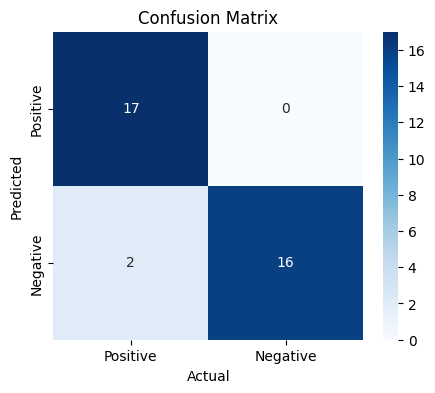

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Input your values here
TP = 17
FP = 2
TN = 16
FN = 0

# Build confusion matrix
conf_matrix = np.array([[TP, FN],
                        [FP, TN]])

# Optional: labels for display
labels = ["Positive", "Negative"]

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix")
plt.show()


## Automated Testing


1.   We unified the clinical data of the patients so that there was a 1-1 correspondence between the patient and their clinical data (following cell)
2.   We defined the functions to generate the responses to the checklist for each case, with zero-shots and with few shots
3.   We did an initial checklist-answer generation for all of the patients in the dataset.
4.   Since it yelded a high number of false-positives we performed a second checklist-answers generation on the cases that were classified as true using few-shots.
5.   We plotted the confusion-matrix of the final results.**testo in grassetto**






restructuring of the dataset into 1-1 patient-clinical data.

In [ ]:
import pandas as pd

# Load csv dataset
df = pd.read_csv("/content/drive/MyDrive/nap/dataset.csv",encoding='latin1')

# Specify number of the patient id and the clinical data columns
id_col = "O03_ID_ACCESSO"
text_col = "O03_TESTO"

# Drop null rows
df = df.dropna(subset=[text_col])

# Unify the clinical data texts pertaining to the same patient
df_unificato = df.groupby(id_col)[text_col].apply(lambda x: "\n".join(x)).reset_index()

# Rename the column
df_unificato.rename(columns={text_col: "testo_completo"}, inplace=True)

# Save the new csv
df_unificato.to_csv("/content/drive/MyDrive/nap/dataset_unificato.csv", index=False)

# Print the first rows
print(df_unificato.head())


  O03_ID_ACCESSO                                     testo_completo
0     PS10000009  I genitori riferiscono che mentre giocava con ...
1     PS10000056  Somministrate 2 cp Bentelan 0,5 mg e 12 gtt fe...
2     PS10000144  Presenza di lesioni pruriginose maculo-papulos...
3     PS10000153  Da ieri comparsa di lesioni vescicolose e macu...
4     PS10000202  Alla rivalutazione netto miglioramento della s...


### Definition of functions
Define the utility function estrai_esito_finale. It takes into input the compiled checklist, it returns TRUE if any of the questions are TRUE, otherwise it returns FALSE.

Define the function genera_checklist_da_caso. It takes the clinical data pertaining to one patient, it retuns as output the compiled checklist.



In [47]:
# function that returns True if at least one question of the checklist is True
def estrai_esito_finale(checklist):
    for riga in checklist.splitlines():
        if "TRUE" in riga.upper():
            return "TRUE"
    return "FALSE"

# zero shot checklist answers generation
def genera_checklist_da_caso(testo_caso):
    prompt = (
        "Leggi il seguente testo clinico e compila la checklist qui sotto. "
        "Per ogni domanda rispondi solo con TRUE o FALSE.\n\n"
        f"TESTO CLINICO:\n{testo_caso}\n\n"
        "CHECKLIST:\n"
        "1. La storia clinica è incoerente?\n"
        "2. C'è stato un ritardo ingiustificato o un mancato accesso alle cure?\n"
        "3. La lesione è compatibile con un abuso o la spiegazione data è vaga, cambiante, o incompatibile con la lesione osservata? ci sono segni di trascuratezza?\n"
        "4. Il comportamento del bambino o dei genitori è inappropriato?\n"
        "5. Altri segnali che fanno dubitare della sicurezza del bambino/famiglia?\n\n"
        "Restituisci SOLO questo formato:\n"
        "1. →\n2. →\n3. →\n4. →\n5. →"
    )
    enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
    print(f"🧮 Token usati: {len(enc.encode(prompt))}")
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "Sei un esperto di medicina legale pediatrica."},
            {"role": "user", "content": prompt}
        ],
        temperature=0,
        max_tokens=200
    )
    return response.choices[0].message.content.strip()


# few shots checklist answers generation
def genera_checklist_da_caso_few_shots(testo_caso):
  prompt = (
      "Leggi il seguente testo clinico e compila la checklist qui sotto. "
      "Per ogni domanda rispondi solo con TRUE o FALSE.\n\n"
      + FEW_SHOTS +
      f"TESTO CLINICO:\n{testo_caso}\n\n"
      "CHECKLIST:\n"
      "1. La storia clinica è incoerente?\n"
      "2. C'è stato un ritardo ingiustificato o un mancato accesso alle cure?\n"
      "3. La lesione è compatibile con un abuso o la spiegazione data è vaga, cambiante, o incompatibile con la lesione osservata? ci sono segni di trascuratezza?\n"
      "4. Il comportamento del bambino o dei genitori è inappropriato?\n"
      "5. Altri segnali che fanno dubitare della sicurezza del bambino/famiglia?\n\n"
      "Restituisci SOLO questo formato:\n"
      "1. →\n2. →\n3. →\n4. →\n5. →"
  )
  enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
  print(f"🧮 Token usati: {len(enc.encode(prompt))}")
  response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
          {"role": "system", "content": "Sei un esperto di medicina legale pediatrica."},
          {"role": "user", "content": prompt}
      ],
      temperature=0,
      max_tokens=200
  )
  return response.choices[0].message.content.strip()

# pause
def safe_genera_checklist(testo_caso):
    while True:
        try:
            return genera_checklist_da_caso(testo_caso)
        except openai.RateLimitError:
            print("⚠️ Rate limit. Aspetto 10s...")
            time.sleep(10)
        except Exception as e:
            print(f"❌ Errore imprevisto: {e}")
            return "ERRORE"

def safe_genera_checklist_few_shots(testo_caso):
    while True:
        try:
            return genera_checklist_da_caso_few_shots(testo_caso)
        except openai.RateLimitError:
            print("⚠️ Rate limit. Aspetto 10s...")
            time.sleep(10)
        except Exception as e:
            print(f"❌ Errore imprevisto: {e}")
            return "ERRORE"

In [50]:
FEW_SHOTS = """
"ESEMPIO 1:\n"
"CASO CLINICO: Il primo caso riguarda un bambino con lividi e abrasioni nella parte bassa della schiena, al ginocchio, al braccio e al viso. La madre ha riferito che il bambino le ha detto che l’insegnante lo aveva picchiato.\n"
"CHECKLIST:\n"
"1. → FALSE\n"
"2. → FALSE\n"
"3. → TRUE\n"
"4. → TRUE (resoconto diretto di violenza)\n"
"5. → FALSE\n\n"

"ESEMPIO 2:\n"
"CASO CLINICO: Il sintomo principale del caso è un resoconto diretto di violenza dato dal bambino.\n"
"CHECKLIST:\n"
"1. → FALSE\n"
"2. → FALSE\n"
"3. → FALSE\n"
"4. → TRUE (resoconto diretto di violenza)\n"
"5. → FALSE\n\n"

"ESEMPIO 3:\n"
"CASO CLINICO: Il bambino presenta ecchimosi multiple e lesioni cutanee minori. Si osservano piccole ecchimosi all’avambraccio destro, ai lati della schiena, al gomito sinistro, escoriazioni alla caviglia destra e altre lesioni. Il bambino ha riferito di essere stato colpito ripetutamente da due compagni. Ha mostrato avversione al ritorno a scuola.\n"
"CHECKLIST:\n"
"1. → FALSE\n"
"2. → FALSE\n"
"3. → TRUE (lesioni compatibili con abuso, in sedi atipiche, in diversi stadi di guarigione)\n"
"4. → TRUE (resoconto diretto e segni di evitamento)\n"
"5. → FALSE\n\n"

"ESEMPIO 4:\n"
"CASO CLINICO: Il bambino presenta un’eruzione pruriginosa tipo orticaria su viso, tronco e arti. Comparsa dopo un pomeriggio al parco.\n"
"CHECKLIST:\n"
"1. → FALSE\n"
"2. → FALSE\n"
"3. → FALSE\n"
"4. → FALSE\n"
"5. → FALSE\n\n"

"ESEMPIO 5:\n"
"CASO CLINICO: Il bambino è stato portato in ospedale per eczema.\n"
"CHECKLIST:\n"
"1. → FALSE\n"
"2. → FALSE\n"
"3. → FALSE\n"
"4. → FALSE\n"
"5. → FALSE\n\n"
"""

In [ ]:
import pandas as pd
import time
import openai
import csv
import os
import tiktoken
from openai import OpenAI

# config
INPUT_CSV = "/content/drive/MyDrive/nap/dataset_unificato.csv"
OUTPUT_CSV = "/content/drive/MyDrive/nap/checklist_outputs.csv"

# DataFrame input
df = pd.read_csv(INPUT_CSV)

# Create set of processed cases
id_processati = set()
if os.path.exists(OUTPUT_CSV):
    with open(OUTPUT_CSV, "r") as f:
        reader = csv.reader(f)
        next(reader, None)
        for row in reader:
            if row: id_processati.add(row[0])

# Open output csv, call safe_genera_checklist function, write on the csv
with open(OUTPUT_CSV, "a", newline="") as f_out:
    writer = csv.writer(f_out)
    if os.stat(OUTPUT_CSV).st_size == 0:
        writer.writerow(["O03_ID_ACCESSO", "checklist_output", "suspectAbuse"])

    for _, row in df.iterrows():
        id_accesso = str(row["O03_ID_ACCESSO"])
        testo = row["testo_completo"]

        if id_accesso in id_processati:
            print(f"⏭️ Già fatto: {id_accesso}")
            continue

        print(f"\n🩺 Analizzo ID {id_accesso}")
        checklist_output = safe_genera_checklist(testo)
        print("📋 Risultato checklist:\n", checklist_output)
        esito = estrai_esito_finale(checklist_output)

        # write line in csv
        writer.writerow([id_accesso, checklist_output, esito])
        f_out.flush()
        print(f"✅ Salvato {id_accesso} → sospetto = {esito}")


Output streaming troncato alle ultime 5000 righe.
⏭️ Già fatto: PS19137004
⏭️ Già fatto: PS19137108
⏭️ Già fatto: PS19137137
⏭️ Già fatto: PS19137213
⏭️ Già fatto: PS19137239
⏭️ Già fatto: PS19137243
⏭️ Già fatto: PS19137357
⏭️ Già fatto: PS19137363
⏭️ Già fatto: PS19137378
⏭️ Già fatto: PS19137620
⏭️ Già fatto: PS19137669
⏭️ Già fatto: PS19137691
⏭️ Già fatto: PS19137717
⏭️ Già fatto: PS19137754
⏭️ Già fatto: PS19137881
⏭️ Già fatto: PS19137892
⏭️ Già fatto: PS19138061
⏭️ Già fatto: PS19138069
⏭️ Già fatto: PS19138075
⏭️ Già fatto: PS19138143
⏭️ Già fatto: PS19138246
⏭️ Già fatto: PS19138262
⏭️ Già fatto: PS19138334
⏭️ Già fatto: PS19138653
⏭️ Già fatto: PS19138667
⏭️ Già fatto: PS19138668
⏭️ Già fatto: PS19138683
⏭️ Già fatto: PS19138700
⏭️ Già fatto: PS19138720
⏭️ Già fatto: PS19138726
⏭️ Già fatto: PS19138739
⏭️ Già fatto: PS19138773
⏭️ Già fatto: PS19138905
⏭️ Già fatto: PS19138910
⏭️ Già fatto: PS19139018
⏭️ Già fatto: PS19139024
⏭️ Già fatto: PS19139132
⏭️ Già fatto: PS19139142


In [9]:
import pandas as pd
import time
import openai
import csv
import os
import tiktoken
from openai import OpenAI

# Config
OUTPUT_CSV = "/content/drive/MyDrive/nap/checklist_outputs.csv"
FINAL_OUT_CSV = "/content/drive/MyDrive/nap/checklist_verified_outputs.csv"

# save all the positive cases in a dataframe df_true
df_all = pd.read_csv(OUTPUT_CSV)
df_true = df_all[df_all['suspectAbuse'] == True]



Function to uniform the checklist outputs

In [12]:
import re

def uniforma_checklist_output(output):
    righe = output.strip().splitlines()
    output_uniformato = []

    for riga in righe:
        # Rimuove eventuali spazi e formatta come "1. → TRUE" ecc.
        match = re.match(r"(\d)\.?\s*[→:-]?\s*(TRUE|FALSE)", riga.strip(), re.IGNORECASE)
        if match:
            numero = match.group(1)
            risposta = match.group(2).upper()
            output_uniformato.append(f"{numero}. → {risposta}")

    return "\n".join(output_uniformato)


In [13]:
# Apply uniforming function
df_true.loc[:, "checklist_output"] = df_true["checklist_output"].apply(uniforma_checklist_output)


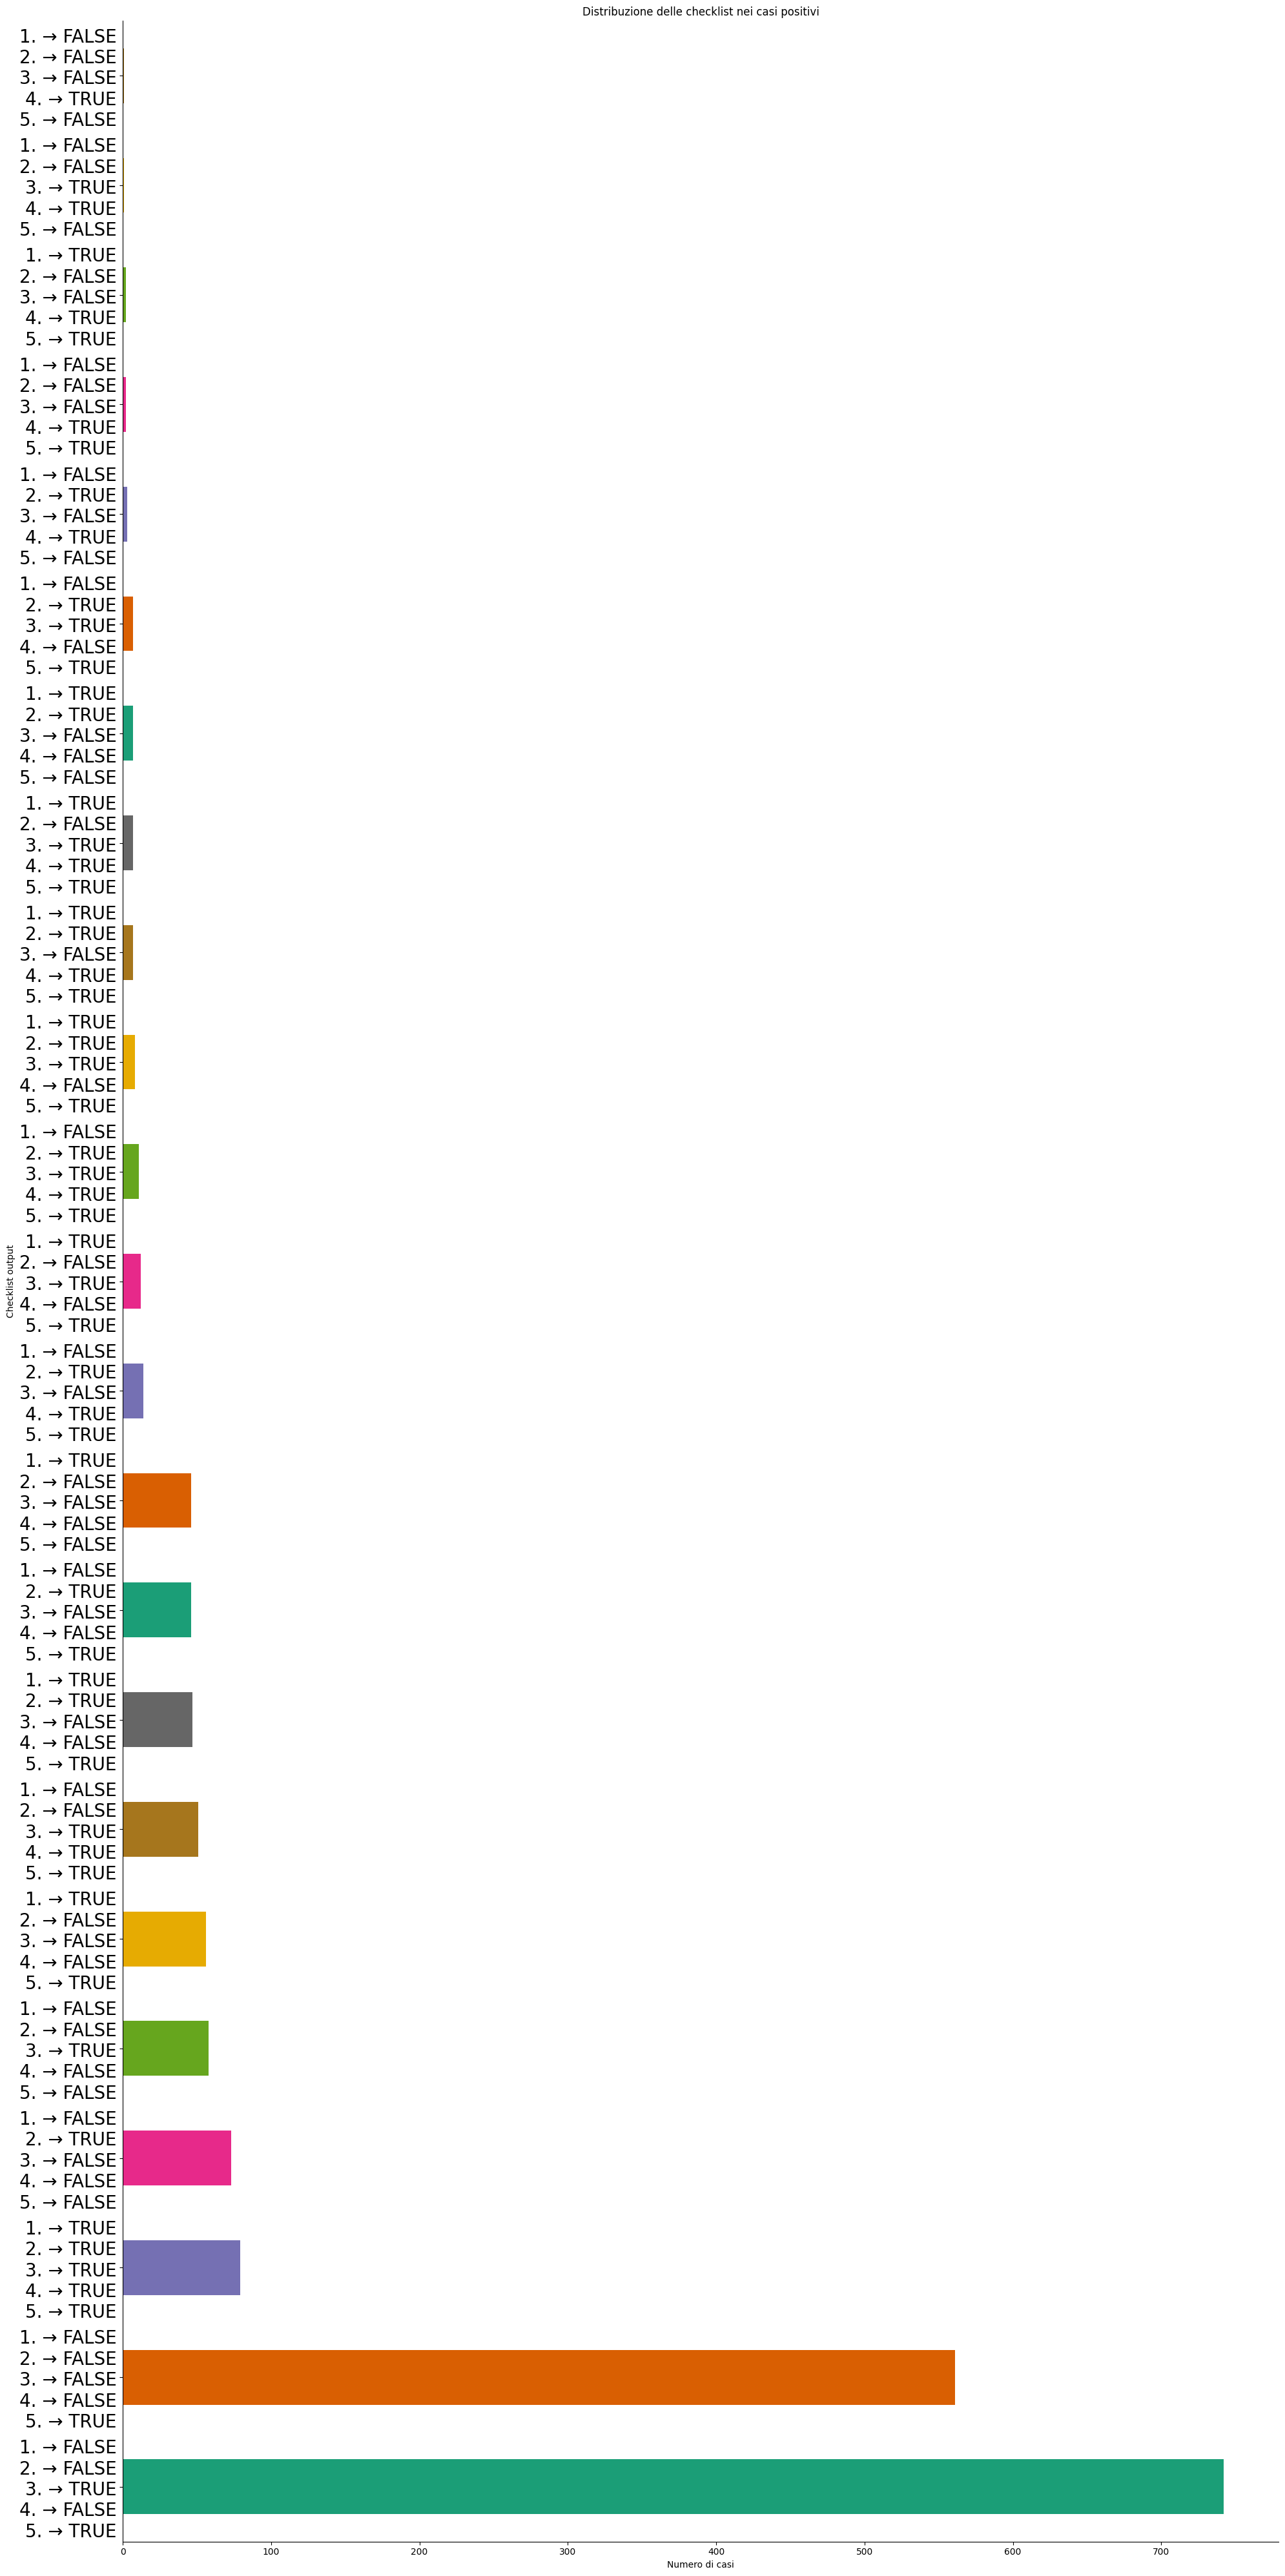

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# Count positives grouping by the answerss of the checklist
checklist_counts = df_true["checklist_output"].value_counts()

# plot
plt.figure(figsize=(20, 40))
checklist_counts.plot(kind="barh", color=sns.color_palette("Dark2"))

plt.xlabel("Numero di casi")
plt.ylabel("Checklist output")
plt.yticks(fontsize=20)
plt.title("Distribuzione delle checklist nei casi positivi")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

Checlist answers generation for the positive cases using few-shots

In [52]:
# Create a set of the already processed cases so that it doesn't start from the start if it's interrupted
id_processati = set()
if os.path.exists(FINAL_OUT_CSV):
    with open(FINAL_OUT_CSV, "r") as f:
        reader = csv.reader(f)
        next(reader, None)
        for row in reader:
            if row: id_processati.add(row[0])

# Call the function to compile the checklists with few shots. Write the answers on the output csv.
with open(FINAL_OUT_CSV, "a", newline="") as f_out:
    writer = csv.writer(f_out)
    if os.stat(FINAL_OUT_CSV).st_size == 0:
        writer.writerow(["O03_ID_ACCESSO", "checklist_output", "suspectAbuse"])

    for _, row in df_true.iterrows():
        id_accesso = str(row["O03_ID_ACCESSO"])
        testo = df_original[df_original['O03_ID_ACCESSO']==id_accesso]['testo_completo']

        if id_accesso in id_processati:
            print(f"⏭️ Già fatto: {id_accesso}")
            continue

        print(f"\n🩺 Analizzo ID {id_accesso}")
        final_checklist_output = safe_genera_checklist_few_shots(testo)
        print("📋 Risultato checklist:\n", final_checklist_output)
        esito = estrai_esito_finale(final_checklist_output)
        print(f"✅ Risultato finale = {esito}")
        # ✅ SCRIVE SUBITO SU CSV
        writer.writerow([id_accesso, final_checklist_output, esito])
        f_out.flush()
        print(f"✅ Salvato {id_accesso} → sospetto = {esito}")


Output streaming troncato alle ultime 5000 righe.
2. → FALSE
3. → FALSE
4. → FALSE
5. → FALSE
✅ Risultato finale = FALSE
✅ Salvato PS17123710 → sospetto = FALSE

🩺 Analizzo ID PS17124765
🧮 Token usati: 765
📋 Risultato checklist:
 1. → FALSE
2. → FALSE
3. → TRUE
4. → TRUE
5. → FALSE
✅ Risultato finale = TRUE
✅ Salvato PS17124765 → sospetto = TRUE

🩺 Analizzo ID PS17124925
🧮 Token usati: 767
📋 Risultato checklist:
 1. → FALSE
2. → FALSE
3. → TRUE
4. → TRUE
5. → FALSE
✅ Risultato finale = TRUE
✅ Salvato PS17124925 → sospetto = TRUE

🩺 Analizzo ID PS17125309
🧮 Token usati: 768
📋 Risultato checklist:
 1. → FALSE
2. → FALSE
3. → FALSE
4. → FALSE
5. → FALSE
✅ Risultato finale = FALSE
✅ Salvato PS17125309 → sospetto = FALSE

🩺 Analizzo ID PS17126767
🧮 Token usati: 768
📋 Risultato checklist:
 1. → FALSE
2. → FALSE
3. → FALSE
4. → FALSE
5. → FALSE
✅ Risultato finale = FALSE
✅ Salvato PS17126767 → sospetto = FALSE

🩺 Analizzo ID PS17127440
🧮 Token usati: 766
📋 Risultato checklist:
 1. → FALSE
2. 

Visualize the results after manual verification of TP TN FP and FN, plotting a confusion matrix

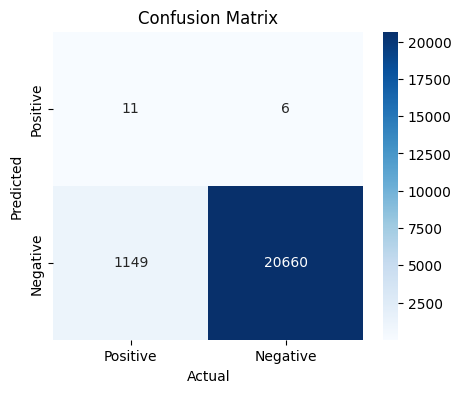

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

positive_vals = int(df_final[df_final['suspectAbuse'] == True]['suspectAbuse'].count())
negative_values = changed_neg_vals + orig_neg_vals

TP = 11 #number of known positives (17) - number of cases that our model defined as negative (6 manually checked)
FP = positive_vals - TP # number of positives found - number of true positives
FN = 6
TN = negative_values - FN # number of all negative values - the false negatives

# Build confusion matrix
conf_matrix = np.array([[TP, FN],
                        [FP, TN]])

# Optional: labels for display
labels = ["Positive", "Negative"]

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix")
plt.show()
